In [2]:
libs <- c(
    'dplyr',
    'tidyr',
    'stringr',
    'ggplot2',
    'GenomicRanges',
    'RPostgreSQL',
    'doMC',
    'numbers'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

# source("http://bioconductor.org/biocLite.R")
# biocLite("BSgenome.Hsapiens.UCSC.hg38")
library(BSgenome.Hsapiens.UCSC.hg38)
hg38 = BSgenome.Hsapiens.UCSC.hg38

In [3]:
source("utility_functions.R")
source("stat_functions.R")
source("plot_functions.R")
source("~/git-repos/BDDS/trenadb/src/utils.R")

## cleaning and splitting functions

In [4]:
# function to split data into independent classifier work set and 
# ensemble classifier work set
split.halves.physically <- function(df, p=0.5, buffer=100) {
    # p is the portion of the data used for independent classifier work
    # the rest is set aside for ensemble classifier work
    
    require("tibble")
    df <- as_data_frame(df)

    df <- ft.clean.corymotifs.tfclasses
    my.center <- (min(df$start) + max(df$end))/2

    first.half.bool.inds <- df$end + buffer/2 < my.center
    second.half.bool.inds <- df$start - buffer/2 > my.center

    first.half.df <- df[first.half.bool.inds,]
    second.half.df <- df[second.half.bool.inds,]
    
    out.list <- list()
    out.list$first.half <- first.half.df
    out.list$second.half <- second.half.df

    return(out.list)
}

# function to split data in to training, testing, and validation sets
split.test.train.valid.physically <- function(df, p.train=0.7, p.test=0.2, p.valid=0.1,
                                              buffer=100, reverse.order=FALSE) {
    
    # physically split: train | test | valid
    
    require("tibble")
    stopifnot(p.train + p.test + p.valid <= 1)
    
    df <- as_data_frame(df[with(df, order(start, decreasing=reverse.order)), ])
    
    tt.split.ind <- round(p.train*nrow(df))
    tv.split.ind <- round((p.train+p.test)*nrow(df))
    
    train.inds.bool <- 1:nrow(df) < tt.split.ind
    valid.inds.bool <- 1:nrow(df) > tv.split.ind
    test.inds.bool <- !(train.inds.bool | valid.inds.bool)
    
    train.df <- df[train.inds.bool,]
    test.df <- df[test.inds.bool,]
    valid.df <- df[valid.inds.bool,]
    
    out.list <- list()
    out.list$train <- train.df
    out.list$test <- test.df
    out.list$valid <- valid.df
    
    return(out.list)
}


# # function to split data into independent classifier work set and 
# # ensemble classifier work set
# split.ic.ec <- function(df, p=0.5) {
#     # p is the portion of the data used for independent classifier work
#     # the rest is set aside for ensemble classifier work
    
#     require("tibble")
    
#     df <- as_data_frame(df)
#     N.all <- dim(df)[1]
    
#     all.inds <- c(1:N.all)
#     ic.inds <- sample(N.all, round(p*N.all), replace=FALSE)
    
#     ic.inds.bool <- all.inds %in% ic.inds
#     ec.inds.bool <- !ic.inds.bool
    
#     ic.df <- df[ic.inds.bool,]
#     ec.df <- df[ec.inds.bool,]
    
#     out.list <- list()
#     out.list$ic <- ic.df
#     out.list$ec <- ec.df

#     return(out.list)
# }


# # function to split data in to training, testing, and validation sets
# split.test.train.valid <- function(df, p.tt=0.75, p.valid=0.25) {
#     # p.valid is the portion of the data set aside for validation
#     # p.tt is the fraction of the remaining data used for training

#     require("tibble")
    
#     df <- as_data_frame(df)
#     N.all <- nrow(df)

#     all.inds <- c(1:N.all)
#     valid.inds <- sample(N.all, round(p.valid*N.all), replace=FALSE)

#     valid.inds.bool <- all.inds %in% valid.inds
#     tt.inds.bool <- !valid.inds.bool
    
#     valid.df <- df[valid.inds.bool,]
#     tt.df <- df[tt.inds.bool,]

#     N.tt <- nrow(tt.df)
#     tt.inds <- c(1:N.tt)
#     train.inds <- sample(N.tt, round(p.tt*N.tt), replace=FALSE)

#     train.inds.bool <- tt.inds %in% train.inds
#     test.inds.bool <- !train.inds.bool

#     train.df <- tt.df[train.inds.bool,]
#     test.df <- tt.df[test.inds.bool,]

#     out.list <- list()
#     out.list$train <- train.df
#     out.list$test <- test.df
#     out.list$valid <- valid.df
    
#     return(out.list)
# }

## Load Data

In [5]:
# df loads as "tb;" variable
load("~/git-repos/BDDS/trenadb/featureTable/lymphoblast/featureTableLymphoblast-chr19-entire.RData")

# remove any duplicate rows
tbl.nodupes <- tbl[!duplicated(tbl),]

# fix spurious zeros in piq score 2 
tmp <- tbl.nodupes$score2.p
tmp[tmp == 0] <- -999
tbl.nodupes$score2.p <- tmp

In [6]:
# cory's motif to tf-class mapping
tf.fams.file <- "/local/Cory/for_Paul/motif_class_fam"
tf.fams.table <- read.delim(tf.fams.file, stringsAsFactors=FALSE)

In [7]:
tf.fams.table

ID,class,family
MA0151.1,ARID domain factors,ARID-related factors
MA0601.1,ARID domain factors,ARID-related factors
MA0602.1,ARID domain factors,ARID-related factors
MA0004.1,Basic helix-loop-helix factors (bHLH),PAS domain factors
MA0048.2,Basic helix-loop-helix factors (bHLH),Tal-related factors
MA0058.3,Basic helix-loop-helix factors (bHLH),bHLH-ZIP factors
MA0093.2,Basic helix-loop-helix factors (bHLH),bHLH-ZIP factors
MA0104.3,Basic helix-loop-helix factors (bHLH),bHLH-ZIP factors
MA0111.1,Basic helix-loop-helix factors (bHLH),-
MA0147.2,Basic helix-loop-helix factors (bHLH),bHLH-ZIP factors


In [8]:
# check overlap of motif names from cory and paul

motif.names.from.cory <- str_replace_all(string=tf.fams.table$ID, pattern="[[:space:]]", repl="")
motif.names.from.paul <- unique(tbl.nodupes$motif)

# motifs not occurring from sample data
from.cory.not.in.paul <- motif.names.from.cory[!(motif.names.from.cory %in% motif.names.from.paul)]

# motifs not mapped in cory's table
from.paul.not.in.cory <- motif.names.from.paul[!(motif.names.from.paul %in% motif.names.from.cory)]

# number of motifs that i'll use
from.paul.in.cory <- sort(motif.names.from.paul[(motif.names.from.paul %in% motif.names.from.cory)])
length(from.paul.in.cory)

[1] 510

In [9]:
# filter out the motifs in pauls' table that cory doesn' have tf classes for
ft.clean.corymotifs <- tbl.nodupes %>% filter(motif %in% from.paul.in.cory)

In [10]:
# find unique tf class names from cory's list

class.names.nospaces <- str_replace_all(string=tf.fams.table$class, pattern="[[:space:]]", repl="")
unique.class.names.nospaces <- unique(class.names.nospaces)
double.entry.classes <- grep('::', unique.class.names.nospaces, value=TRUE)
dedoubled.classes <- unique(unlist(strsplit(double.entry.classes,'::')))

class.names.nospaces.minus.doubles <- unique.class.names.nospaces[!(unique.class.names.nospaces %in% double.entry.classes)]
class.names.final <- sort(unique(c(class.names.nospaces.minus.doubles,dedoubled.classes)))
length(class.names.final)

[1] 30

In [11]:
# cory's map: arrange so grepping on class column will yeild matches from paul's names

tf.fams.table.renamed <- tf.fams.table
tf.fams.table.renamed$ID <- str_replace_all(string=tf.fams.table.renamed$ID, pattern="[[:space:]]", repl="")
tf.fams.table.renamed <- tf.fams.table.renamed %>% filter(ID %in% from.paul.in.cory)
rownames(tf.fams.table.renamed) <- tf.fams.table.renamed$ID
tf.class.foreach.motif <- tf.fams.table.renamed[,-c(1)]

tf.class.foreach.motif$class <- str_replace_all(string=tf.class.foreach.motif$class, pattern="[[:space:]]", repl="")

In [12]:
# make sparse class / tf feature matrix map
# all zeros to start, fill in ones below
tf.motif.class.matrix <- matrix(0L, nrow = length(from.paul.in.cory), ncol = length(class.names.final))
rownames(tf.motif.class.matrix) <- from.paul.in.cory
colnames(tf.motif.class.matrix) <- class.names.final

# loop through tfs and classes to fill in ones where there is a match

for (tf.name in rownames(tf.motif.class.matrix)) {
    for (class.name in colnames(tf.motif.class.matrix)) {
        class.to.check <- tf.class.foreach.motif[tf.name,'class']
        classes.match <- any(grep(class.name, class.to.check, value=FALSE, fixed=TRUE))
        if (classes.match == 1) {
            tf.motif.class.matrix[tf.name,class.name] <- 1
        }
    }
    
}

In [39]:
# number of motifs with extra entries is small:
dim(tf.motif.class.matrix)
sum(tf.motif.class.matrix)

# check to see if any motifs didn't match
rownames(tf.motif.class.matrix)[rowSums(tf.motif.class.matrix) == 0]

[1] 510  30

[1] 513

character(0)

In [55]:
colSums(tf.motif.class.matrix) == 0

ARIDdomainfactors   Basichelix-loop-helixfactors(bHLH) 
                               FALSE                                FALSE 
  Basichelix-span-helixfactors(bHSH)      Basicleucinezipperfactors(bZIP) 
                               FALSE                                FALSE 
      C2CHTHAP-typezincfingerfactors                C2H2zincfingerfactors 
                               FALSE                                FALSE 
                           CRCdomain  DM-typeintertwinedzincfingerfactors 
                               FALSE                                FALSE 
         Forkhead/wingedhelixfactors                     GCMdomainfactors 
                               FALSE                                FALSE 
             Grainyheaddomainfactors                     Heatshockfactors 
                               FALSE                                FALSE 
     HeteromericCCAAT-bindingfactors High-mobilitygroup(HMG)domainfactors 
                               FALSE                                FALSE 
                  Homeodomainfactors                       MADSboxfactors 
                               FALSE                                FALSE 
   NuclearreceptorswithC4zincfingers        OtherC4zincfinger-typefactors 
                               FALSE                                FALSE 
                    p53domainfactors                     Pairedboxfactors 
                               FALSE                                FALSE 
                   Psq-typeHTHdomain        Relhomologyregion(RHR)factors 
                               FALSE                                FALSE 
                   Runtdomainfactors                    SANDdomainfactors 
                               FALSE                                FALSE 
   SMAD/NF-1DNA-bindingdomainfactors                    STATdomainfactors 
                               FALSE                                FALSE 
                        T-Boxfactors                 TATA-bindingproteins 
                               FALSE                                FALSE 
                    TEAdomainfactors             Tryptophanclusterfactors 
                               FALSE                                FALSE

In [49]:
doubles <- tf.motif.class.matrix[rownames(tf.motif.class.matrix)[rowSums(tf.motif.class.matrix) == 2],]
doubles[,colnames(doubles)[colSums(doubles) > 0]]

,Basichelix-loop-helixfactors(bHLH),High-mobilitygroup(HMG)domainfactors,Homeodomainfactors,OtherC4zincfinger-typefactors,SMAD/NF-1DNA-bindingdomainfactors
MA0119.1,0,0,1,0,1
MA0140.2,1,0,0,1,0
MA0142.1,0,1,1,0,0


In [14]:
tf.class.names <- colnames(tf.motif.class.matrix)
tf.class.names

[1] "ARIDdomainfactors"                   
 [2] "Basichelix-loop-helixfactors(bHLH)"  
 [3] "Basichelix-span-helixfactors(bHSH)"  
 [4] "Basicleucinezipperfactors(bZIP)"     
 [5] "C2CHTHAP-typezincfingerfactors"      
 [6] "C2H2zincfingerfactors"               
 [7] "CRCdomain"                           
 [8] "DM-typeintertwinedzincfingerfactors" 
 [9] "Forkhead/wingedhelixfactors"         
[10] "GCMdomainfactors"                    
[11] "Grainyheaddomainfactors"             
[12] "Heatshockfactors"                    
[13] "HeteromericCCAAT-bindingfactors"     
[14] "High-mobilitygroup(HMG)domainfactors"
[15] "Homeodomainfactors"                  
[16] "MADSboxfactors"                      
[17] "NuclearreceptorswithC4zincfingers"   
[18] "OtherC4zincfinger-typefactors"       
[19] "p53domainfactors"                    
[20] "Pairedboxfactors"                    
[21] "Psq-typeHTHdomain"                   
[22] "Relhomologyregion(RHR)factors"       
[23] "Runtdomainfactors"                   
[24] "SANDdomainfactors"                   
[25] "SMAD/NF-1DNA-bindingdomainfactors"   
[26] "STATdomainfactors"                   
[27] "T-Boxfactors"                        
[28] "TATA-bindingproteins"                
[29] "TEAdomainfactors"                    
[30] "Tryptophanclusterfactors"

In [15]:
# merging is a way saner way to... merge dataframes, who knew?
tf.motif.class.df <- as.data.frame(tf.motif.class.matrix)
tf.motif.class.df$motif <- rownames(tf.motif.class.df)
dim(tf.motif.class.df)

ft.clean.corymotifs.tfclasses <- merge(ft.clean.corymotifs, tf.motif.class.df, by="motif", all.x=TRUE)
dim(ft.clean.corymotifs.tfclasses)

[1] 510  31

[1] 1136194      51

In [16]:
# check to see if any loc/motifs didn't get a class
rownames(ft.clean.corymotifs.tfclasses)[rowSums(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)]) == 0]

character(0)

In [17]:
# most entries just have one class
dim(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])[1]
sum(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])

[1] 1136194

[1] 1139416

## add distance to TSS and GC content as features

### check to find optimal window for GC content

In [18]:
get.gc.content <- function(df, b=50) {
    require(GenomicRanges)
    
    df$center <- round((df$start + df$end)/2)
    windows <- getSeq(hg38, "chr19", df$center-b, df$center+b)

    alph.freq <- alphabetFrequency(windows)
    gc.content <- rowSums(alph.freq[,c("C","G")])/(2*b+1)
    
    return(gc.content)
}

KL.divergence <- function(df, b=50) {
    
    require(GenomicRanges)

    # p is base measure (true binding sites)
    # q is new distribution (false binding sites)

    true.pos.df <- df[df$csscore != 0,]
    false.pos.df <- df[df$csscore == 0,]

    distribution.p <- get.gc.content(true.pos.df, b=b)
    distribution.q <- get.gc.content(false.pos.df, b=b)
    
    breaks <- seq(from=0, to=1, length.out=2*(b+1)+1)

    p <- hist(distribution.p, breaks=breaks, plot=FALSE)
    p <- p$density/sum(p$density)
    
    q <- hist(distribution.q, breaks=breaks, plot=FALSE)
    q <- q$density/sum(q$density)

    # need q=0 => p=0 for KL divergence to be defined
    p[q==0] <- 0

    pq.ratio <- p/q
    
    # fix div by zero
    pq.ratio[is.na(pq.ratio)] <- 1
    
    # fix what will be -inf after log
    pq.ratio[pq.ratio==0] <- 1
    
    log.pq.ratio <- log(pq.ratio)
    p.log.pq.ratio <- p*log.pq.ratio
    KL.pq <- sum(p.log.pq.ratio)
    
    return(KL.pq)
}

In [19]:
# my.df <- ft.clean.corymotifs.tfclasses

# KL.divergence.my.df <- function(b) {
#     return(KL.divergence(my.df, b=b))
# }

In [20]:
# bs <- c(1,5,10,25,50,100,250,500,1000,2500,5000,10000)
# registerDoMC(cores=length(bs))

In [21]:
# KL.D.bs <- foreach(n=bs, .combine = c) %dopar% KL.divergence.my.df(n)

In [22]:
# names(KL.D.bs) <- bs
# KL.D.bs

In [23]:
# bs <- seq(from=50, to=500, length.out = 10+1)
# registerDoMC(cores=length(bs))

# KL.D.bs <- foreach(n=bs, .combine = c) %dopar% KL.divergence.my.df(n)
# names(KL.D.bs) <- bs

In [24]:
# plot(names(KL.D.bs), KL.D.bs, ylim=c(0,1))
# KL.D.bs

### looks like window = 100 is pretty good

In [25]:
gc.content <- get.gc.content(ft.clean.corymotifs.tfclasses, b=100)
ft.clean.corymotifs.tfclasses$gc.content <- gc.content

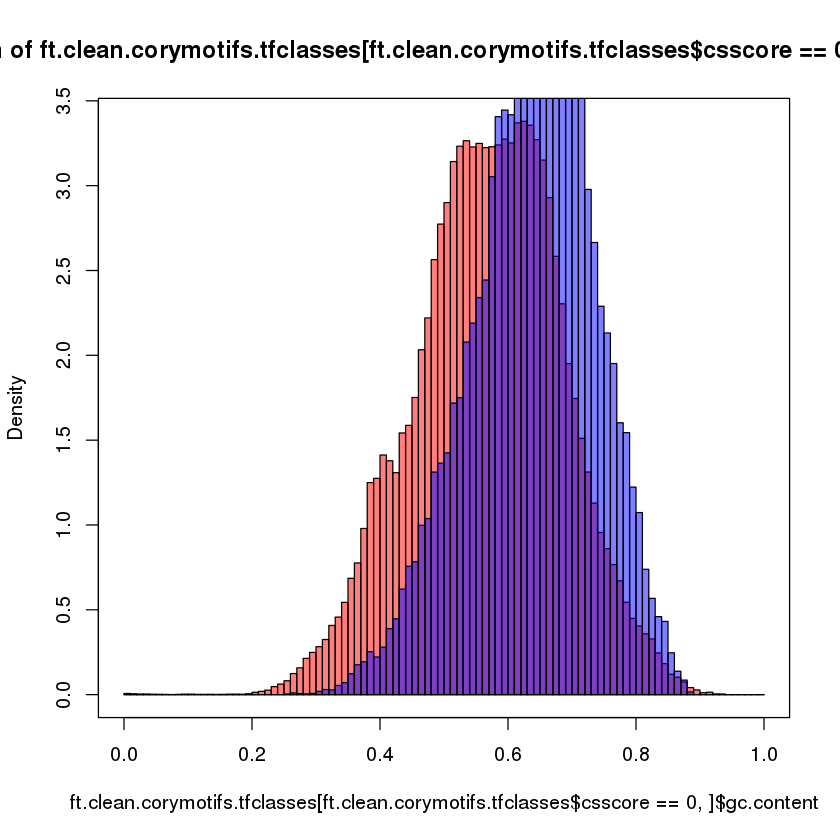

In [26]:
# Histogram Colored (blue and red)

breaks <- seq(from=0, to=1, length.out=(100+1))
hist(ft.clean.corymotifs.tfclasses[ft.clean.corymotifs.tfclasses$csscore==0,]$gc.content, 
     breaks = breaks, freq = FALSE, col=rgb(1,0,0,0.5))
hist(ft.clean.corymotifs.tfclasses[ft.clean.corymotifs.tfclasses$csscore!=0,]$gc.content, 
     breaks = breaks, freq = FALSE, col=rgb(0,0,1,0.5), add=TRUE)
box()

## add TSS distance as feature

In [27]:
db.gtf <- dbConnect(PostgreSQL(), user= "trena", password="trena", dbname="gtf", host="whovian")
query <- "select * from hg38human where moleculetype='gene' and gene_biotype='protein_coding'"
tss.tbl <- dbGetQuery(db.gtf, query)[, c("chr", "gene_name", "start", "endpos","strand")]

tss.start <- vector(mode="numeric", length=nrow(tss.tbl))
tss.start[tss.tbl$strand == "+"] <- tss.tbl[tss.tbl$strand == "+",]$start
tss.start[tss.tbl$strand == "-"] <- tss.tbl[tss.tbl$strand == "-",]$endpos
tss.tbl$tss.start <- tss.start
tss.tbl <- tss.tbl[,c("chr", "tss.start")]

In [28]:
x <- ft.clean.corymotifs.tfclasses
gr.19 <- GRanges(seqnames="chr19", IRanges(start=x$start, end=x$end))
tss.gr <- GRanges(seqnames=tss.tbl$chr, IRanges(start=tss.tbl$tss.start, end=tss.tbl$tss.start))
dist.to.nearest.tss <- distanceToNearest(gr.19, tss.gr, select="arbitrary")
tss.dists <- mcols(dist.to.nearest.tss)[,1]

In [29]:
ft.clean.corymotifs.tfclasses$log.TSS.dist <- log(tss.dists+1)

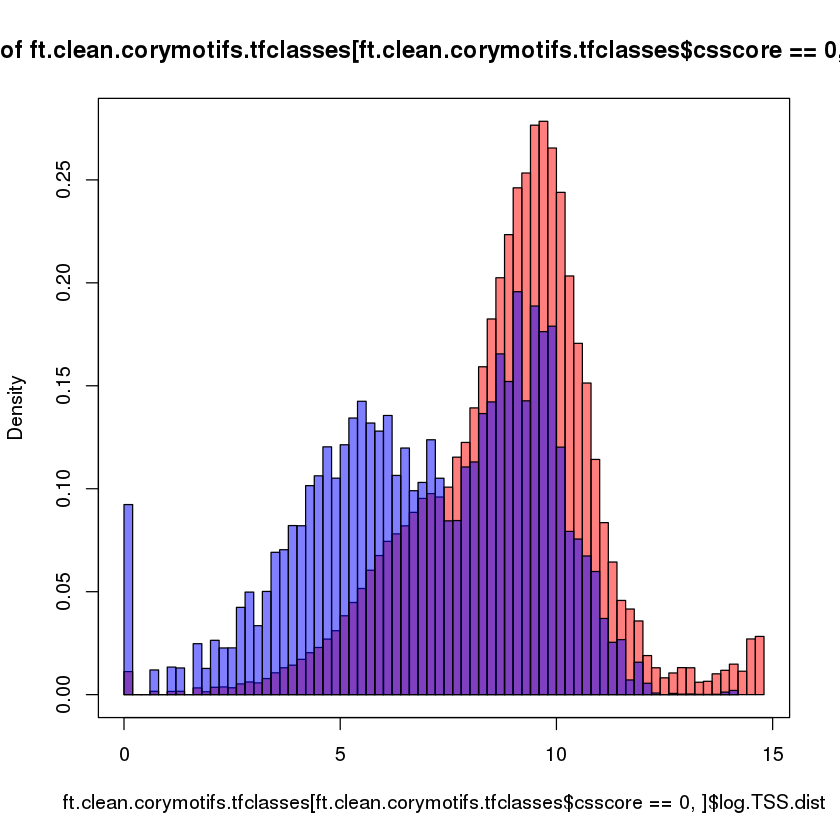

In [30]:
# Histogram Colored (blue and red)
hist(ft.clean.corymotifs.tfclasses[ft.clean.corymotifs.tfclasses$csscore==0,]$log.TSS.dist, 
     breaks = 100, freq = FALSE, col=rgb(1,0,0,0.5))
hist(ft.clean.corymotifs.tfclasses[ft.clean.corymotifs.tfclasses$csscore!=0,]$log.TSS.dist, 
     breaks = 100, freq = FALSE, col=rgb(0,0,1,0.5), add=TRUE)
box()

## Split data into different sets

In [31]:
# split into test, train, validation dfs for both
# independent classifier (ic) and ensemble classifier(ec) work
# ic and ec are on different halfs of the chromasome, so no potential for overlap

halves.list <- split.halves.physically(ft.clean.corymotifs.tfclasses)

first.half.df <- halves.list$first.half
second.half.df <- halves.list$second.half

Loading required package: tibble


In [32]:
first.half.train.test.valid.list <- split.test.train.valid.physically(first.half.df, reverse.order = TRUE)
second.half.train.test.valid.list <- split.test.train.valid.physically(second.half.df, reverse.order = FALSE)

first.half.train.df <- first.half.train.test.valid.list$train
first.half.test.df <- first.half.train.test.valid.list$test
first.half.valid.df <- first.half.train.test.valid.list$valid

second.half.train.df <- second.half.train.test.valid.list$train
second.half.test.df <- second.half.train.test.valid.list$test
second.half.valid.df <- second.half.train.test.valid.list$valid

In [33]:
nrow(first.half.df) + nrow(second.half.df)

nrow(first.half.train.df) + nrow(first.half.test.df) + nrow(first.half.valid.df)
nrow(second.half.train.df) + nrow(second.half.test.df) + nrow(second.half.valid.df)

[1] 1136194

[1] 585747

[1] 550447

In [34]:
# can't just split on loc, need to sort on loc and then split by quantile...
# no need for new computations, can just sort on start colunn then split

tmp.first.half.train.df <- first.half.train.df
tmp.first.half.test.df <- first.half.test.df
tmp.first.half.valid.df <- first.half.valid.df
tmp.second.half.train.df <- second.half.train.df
tmp.second.half.test.df <- second.half.test.df
tmp.second.half.valid.df <- second.half.valid.df

tmp.first.half.train.df$type <- "f.train"
tmp.first.half.test.df$type <- "f.test"
tmp.first.half.valid.df$type <- "f.valid"
tmp.second.half.train.df$type <- "s.train"
tmp.second.half.test.df$type <- "s.test"
tmp.second.half.valid.df$type <- "s.valid"

tot.df <- rbind(
    tmp.first.half.train.df,
    tmp.first.half.test.df,
    tmp.first.half.valid.df,
    tmp.second.half.train.df,
    tmp.second.half.test.df,
    tmp.second.half.valid.df)

# mean(first.half.train.df$csscore > 0)
# mean(first.half.test.df$csscore > 0)
# mean(first.half.valid.df$csscore > 0)
# mean(second.half.train.df$csscore > 0)
# mean(second.half.test.df$csscore > 0)
# mean(second.half.valid.df$csscore > 0)

In [35]:
p <- ggplot(tot.df) +
    geom_histogram(aes(x=start, fill=type), bins=1000) +
    theme_minimal()

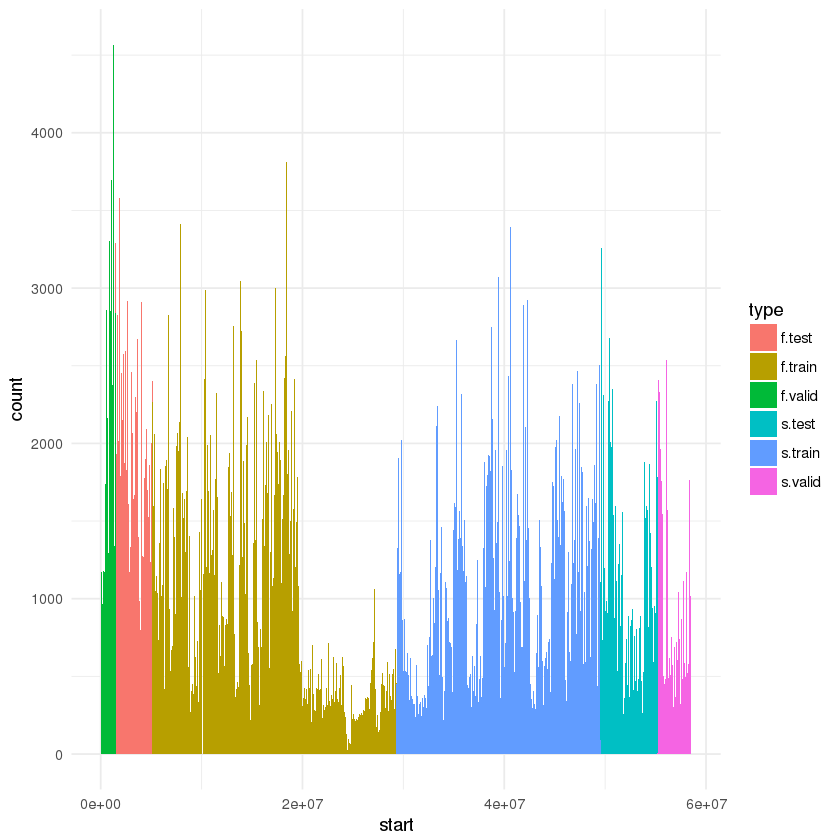

In [36]:
p

In [38]:
all.clean.df <- ft.clean.corymotifs.tfclasses

old.all.clean.df <- all.clean.df
save(old.all.clean.df,
#      first.half.train.df,
#      first.half.test.df,
#      first.half.valid.df,
#      second.half.train.df,
#      second.half.test.df,
#      second.half.valid.df,
     tf.class.names,
     file="old_train_test_valid_data_sets.Rdata")

In [6]:
load("~/git-repos/BDDS/trenadb/featureTable/lymphoblast/featureTableLymphoblast-chr19-entire.RData")
write.table(unique(tbl$csTF), file='tflist.txt', row.names = FALSE, quote = FALSE)

In [9]:
table(tbl$csTF)["MEF2C"]

MEF2C 
  308